# Data Reading and Time Series Construction

<ipython-input-1-54e381b0919e>:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_all['datetime'] = pd.to_datetime(df_all['date'].astype(str) + ' ' + df_all['time'])


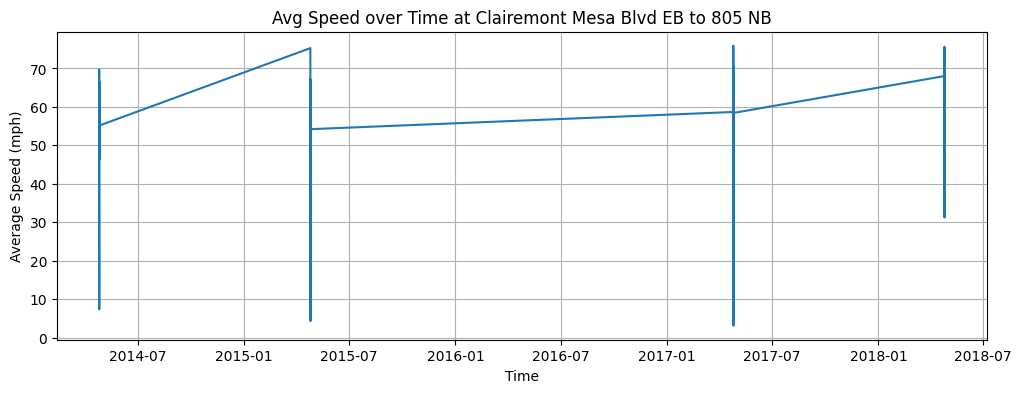

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_14 = pd.read_csv('250414model_ready_output_final.csv')
df_15 = pd.read_csv('250415model_ready_output_final.csv')
df_17 = pd.read_csv('250417model_ready_output_final.csv')
df_18 = pd.read_csv('250418model_ready_output_final.csv')

df_all = pd.concat([df_14, df_15, df_17, df_18], ignore_index=True)

df_all['datetime'] = pd.to_datetime(df_all['date'].astype(str) + ' ' + df_all['time'])

df_all = df_all.sort_values(by='datetime')

location = "Clairemont Mesa Blvd EB to 805 NB"
df_loc = df_all[df_all['location'] == location].copy()

plt.figure(figsize=(12,4))
plt.plot(df_loc['datetime'], df_loc['avg_speed'])
plt.title(f"Avg Speed over Time at {location}")
plt.xlabel("Time")
plt.ylabel("Average Speed (mph)")
plt.grid(True)
plt.show()

# Takens Embedding and Persistent Diagram Construction

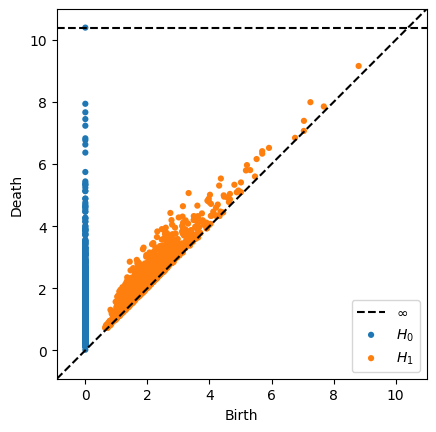

In [4]:
from ripser import ripser
from persim import plot_diagrams

series = df_all[df_all['location'] == "Clairemont Mesa Blvd EB to 805 NB"].sort_values(by='datetime')['avg_speed'].dropna().values

def takens_embedding(ts, dim=3, delay=1):
    N = len(ts) - (dim - 1) * delay
    return np.array([ts[i:i + dim * delay:delay] for i in range(N)])

X = takens_embedding(series, dim=3, delay=1)

diagrams = ripser(X, maxdim=1)['dgms']

plot_diagrams(diagrams, show=True)

# Question 1: Peak vs Off-Peak Persistent Diagram

<ipython-input-9-292f57ee03ca>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_loc['hour'] = pd.to_datetime(df_loc['time']).dt.hour


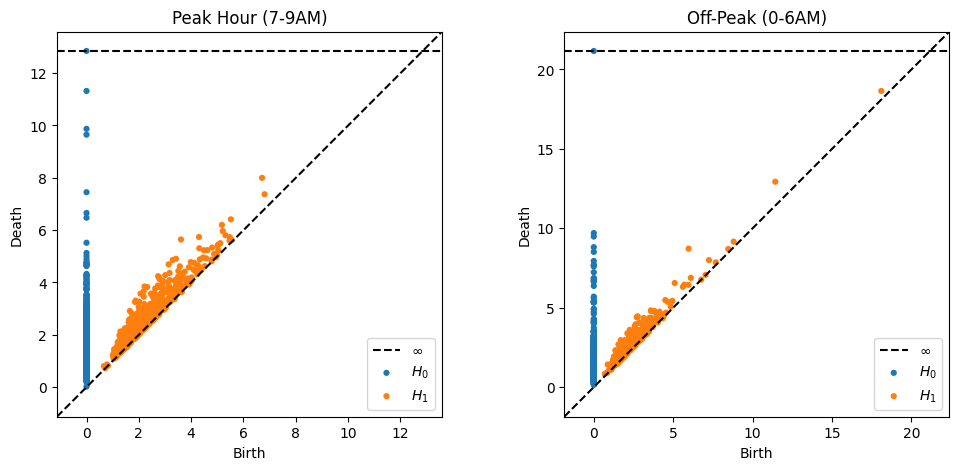

In [9]:
df_loc['hour'] = pd.to_datetime(df_loc['time']).dt.hour

peak_series = df_loc[(df_loc['hour'] >= 7) & (df_loc['hour'] <= 9)]['avg_speed'].dropna().values

offpeak_series = df_loc[(df_loc['hour'] >= 0) & (df_loc['hour'] <= 6)]['avg_speed'].dropna().values

def takens_embedding(ts, dim=3, delay=1):
    N = len(ts) - (dim - 1) * delay
    if N <= 0:
        return np.array([])
    return np.array([ts[i:i + dim * delay:delay] for i in range(N)])

X_peak = takens_embedding(peak_series, dim=3, delay=1)
X_off = takens_embedding(offpeak_series, dim=3, delay=1)

if len(X_peak) > 0:
    dgms_peak = ripser(X_peak, maxdim=1)['dgms']
else:
    dgms_peak = []

if len(X_off) > 0:
    dgms_off = ripser(X_off, maxdim=1)['dgms']
else:
    print("Warning: Off-peak series is empty. Cannot compute persistent diagrams.")


fig, axs = plt.subplots(1, 2, figsize=(12, 5))

if len(dgms_peak) > 0:
    plot_diagrams(dgms_peak, show=False, ax=axs[0])
axs[0].set_title("Peak Hour (7-9AM)")

if len(dgms_off) > 0:
    plot_diagrams(dgms_off, show=False, ax=axs[1])
axs[1].set_title("Off-Peak (0-6AM)")

plt.show()

**Filtered Persistence Diagrams: Peak vs Off-Peak (Persistence > 0.5)**

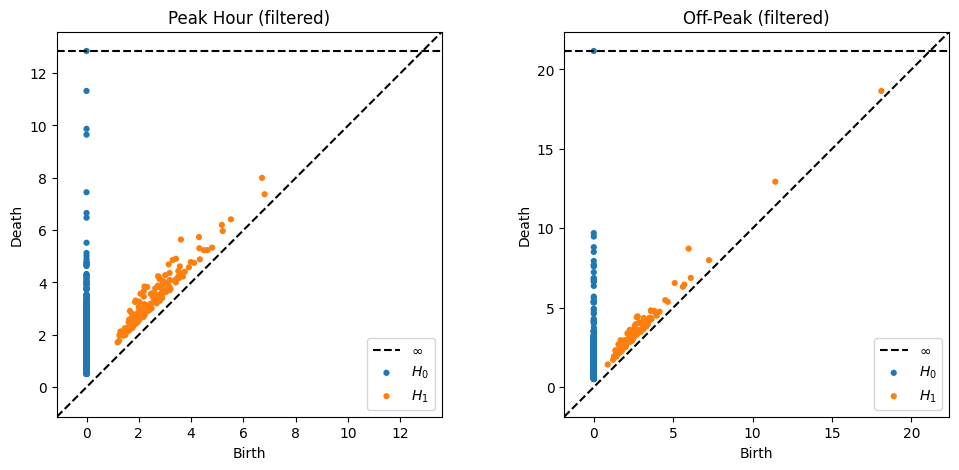

In [10]:
def filter_diagram(diagram, min_persistence=0.5):
    return np.array([pt for pt in diagram if (pt[1] - pt[0]) > min_persistence])

dgms_peak_filtered = [filter_diagram(dgm, min_persistence=0.5) for dgm in dgms_peak]
dgms_off_filtered = [filter_diagram(dgm, min_persistence=0.5) for dgm in dgms_off]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
plot_diagrams(dgms_peak_filtered, show=False, ax=axs[0])
axs[0].set_title("Peak Hour (filtered)")
plot_diagrams(dgms_off_filtered, show=False, ax=axs[1])
axs[1].set_title("Off-Peak (filtered)")
plt.show()

**Topological Distance Between Peak and Off-Peak**

In [12]:
from persim import bottleneck

def get_max_persistence(diagram):
    if len(diagram) == 0:
        return 0
    return np.max([pt[1] - pt[0] for pt in diagram])

max_persistence_peak = get_max_persistence(dgms_peak[1])
max_persistence_off = get_max_persistence(dgms_off[1])

distance = bottleneck(dgms_peak[1], dgms_off[1])
distance

np.float64(0.8119382858276367)

# Question 2: Location Clustering via Persistence Diagrams and Images

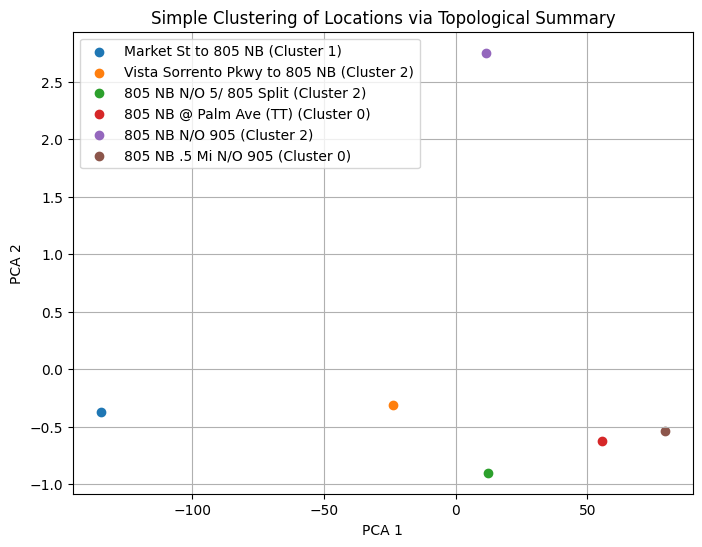

In [13]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

locations = df_all['location'].value_counts().head(6).index.tolist()

features = []
labels = []

def get_max_persistence(diagram):
    if len(diagram) == 0:
        return 0
    return np.max([pt[1] - pt[0] for pt in diagram])

for loc in locations:
    series = df_all[df_all['location'] == loc].sort_values(by='datetime')['avg_speed'].dropna().values
    if len(series) < 10: continue

    X = takens_embedding(series, dim=3, delay=1)
    if len(X) == 0: continue

    dgm = ripser(X, maxdim=1)['dgms'][1]
    num_H1 = len(dgm)
    max_H1 = get_max_persistence(dgm)

    features.append([num_H1, max_H1])
    labels.append(loc)

features = np.array(features)
kmeans = KMeans(n_clusters=3, random_state=0).fit(features)
cluster_labels = kmeans.labels_

pca = PCA(n_components=2)
reduced = pca.fit_transform(features)

plt.figure(figsize=(8,6))
for i in range(len(labels)):
    plt.scatter(reduced[i, 0], reduced[i, 1], label=f"{labels[i]} (Cluster {cluster_labels[i]})")
plt.title("Simple Clustering of Locations via Topological Summary")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.show()

**Persistence Image Vector**


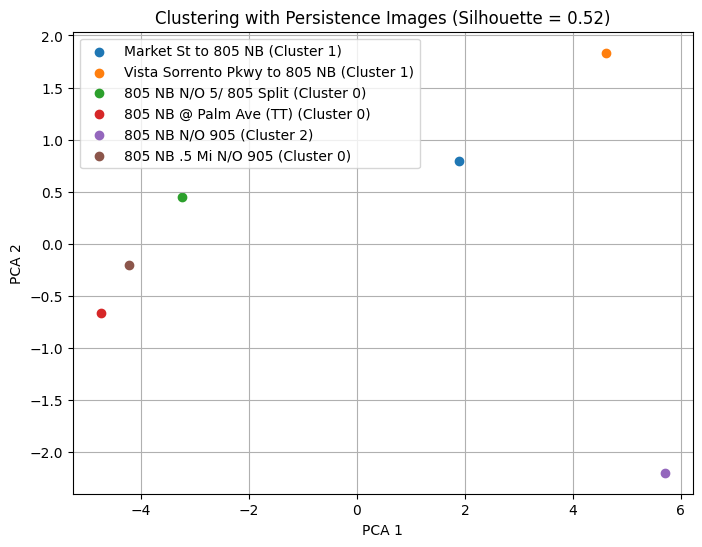

In [16]:
from persim import PersistenceImager
from sklearn.metrics import silhouette_score


pi = PersistenceImager(pixel_size=0.1)

all_dgms = []
locations = df_all['location'].value_counts().head(6).index.tolist()
valid_labels = []

for loc in locations:
    series = df_all[df_all['location'] == loc].sort_values(by='datetime')['avg_speed'].dropna().values
    if len(series) < 10:
        continue

    X = takens_embedding(series, dim=3, delay=1)
    if len(X) == 0:
        continue

    dgm = ripser(X, maxdim=1)['dgms'][1]
    if len(dgm) > 0:
        all_dgms.append(dgm)
        valid_labels.append(loc)

if all_dgms:
    combined_dgms = np.concatenate(all_dgms)
    pi.fit(combined_dgms)

    vectors = []
    for dgm in all_dgms:
        img = pi.transform(dgm)
        vectors.append(img.flatten())

    vectors = np.array(vectors)

    kmeans = KMeans(n_clusters=3, random_state=0).fit(vectors)
    cluster_labels = kmeans.labels_
    sil_score = silhouette_score(vectors, cluster_labels)

    reduced = PCA(n_components=2).fit_transform(vectors)

    plt.figure(figsize=(8,6))D
    for i in range(len(valid_labels)):
        plt.scatter(reduced[i, 0], reduced[i, 1], label=f"{valid_labels[i]} (Cluster {cluster_labels[i]})")
    plt.title(f"Clustering with Persistence Images (Silhouette = {sil_score:.2f})")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    print("No valid persistence diagrams were generated for the selected locations.")

**Mapper**


In [19]:
import kmapper as km
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN

scaler = MinMaxScaler()
vectors_scaled = scaler.fit_transform(vectors)

mapper = km.KeplerMapper()

projected = mapper.fit_transform(vectors_scaled, projection=PCA(n_components=2))

graph = mapper.map(projected, vectors_scaled, clusterer=DBSCAN(eps=0.5, min_samples=1), cover=km.Cover(n_cubes=5, perc_overlap=0.5))

labels_np = np.array(labels)

mapper.visualize(graph,
                 path_html="mapper_Q2.html",
                 title="Mapper Graph of Traffic Locations via Persistence Image",
                 custom_tooltips=labels_np)

'<!DOCTYPE html>\n<html>\n\n<head>\n  <meta charset="utf-8">\n  <meta name="generator" content="KeplerMapper">\n  <title>Mapper Graph of Traffic Locations via Persistence Image | KeplerMapper</title>\n\n  <link rel="icon" type="image/png" href="http://i.imgur.com/axOG6GJ.jpg" />\n\n  <link href=\'https://fonts.googleapis.com/css?family=Roboto+Mono:700,300\' rel=\'stylesheet\' type=\'text/css\'>\n  <style>* {\n  margin: 0;\n  padding: 0;\n}\n\nhtml, body {\n  height: 100%;\n}\n\nbody {\n  font-family: "Roboto Mono", "Helvetica", sans-serif;\n  font-size: 14px;\n}\n\n#logo {\n  width:  85px;\n  height: 85px;\n}\n\n#display {\n  color: #95A5A6;\n  background: #212121;\n}\n\n#header {\n  background: #111111;\n}\n\n#print {\n  color: #000;\n  background: #FFF;\n}\n\nh1 {\n  font-size: 21px;\n  font-weight: 300;\n  font-weight: 300;\n}\n\nh2 {\n  font-size: 18px;\n  padding-bottom: 20px;\n  font-weight: 300;\n}\n\nh3 {\n  font-size: 14px;\n  font-weight: 700;\n  text-transform: uppercase;\n}

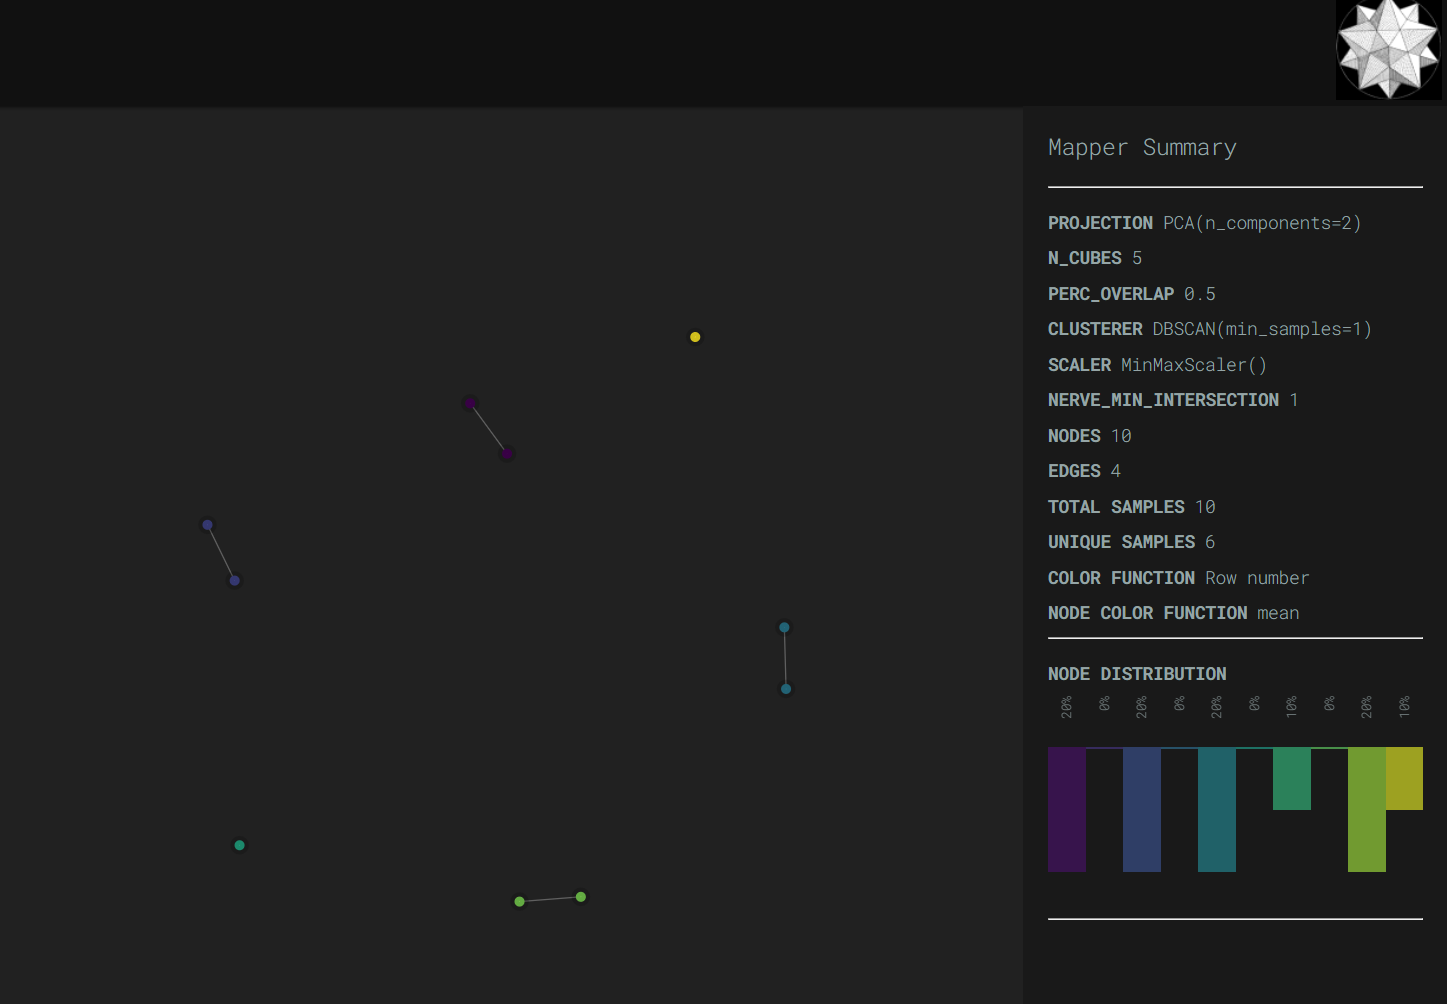

# Question 3: Topological Features vs Statistical Summaries in Clustering

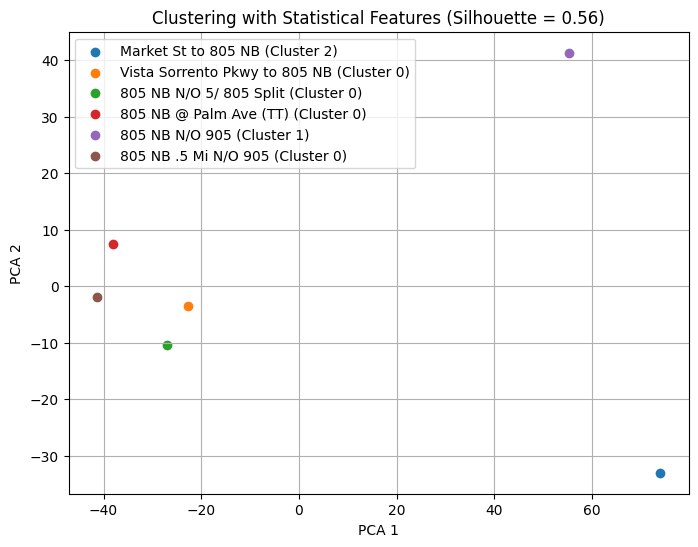

In [24]:
from sklearn.metrics import silhouette_score

stat_features = []
stat_labels = []

for loc in labels:
    series = df_all[df_all['location'] == loc].sort_values(by='datetime')['avg_speed'].dropna().values
    if len(series) < 10: continue
    mean_val = np.mean(series)
    std_val = np.std(series)
    max_val = np.max(series)
    min_val = np.min(series)
    stat_features.append([mean_val, std_val, max_val, min_val])
    stat_labels.append(loc)

stat_features = np.array(stat_features)

kmeans_stat = KMeans(n_clusters=3, random_state=0).fit(stat_features)
stat_cluster_labels = kmeans_stat.labels_
stat_sil_score = silhouette_score(stat_features, stat_cluster_labels)

reduced_stat = PCA(n_components=2).fit_transform(stat_features)

plt.figure(figsize=(8,6))
for i in range(len(stat_labels)):
    plt.scatter(reduced_stat[i, 0], reduced_stat[i, 1], label=f"{stat_labels[i]} (Cluster {stat_cluster_labels[i]})")
plt.title(f"Clustering with Statistical Features (Silhouette = {stat_sil_score:.2f})")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.show()

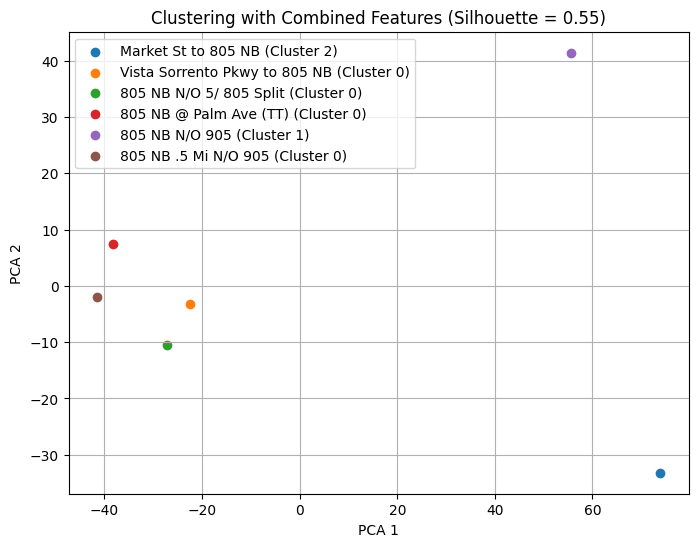

In [26]:
from sklearn.cluster import DBSCAN

locations = df_all['location'].value_counts().head(6).index.tolist()
valid_labels = []
all_dgms = []

for loc in locations:
    series = df_all[df_all['location'] == loc].sort_values(by='datetime')['avg_speed'].dropna().values
    if len(series) < 10:
        continue
    def takens_embedding(ts, dim=3, delay=1):
        N = len(ts) - (dim - 1) * delay
        if N <= 0:
            return np.array([])
        return np.array([ts[i:i + dim * delay:delay] for i in range(N)])

    X = takens_embedding(series, dim=3, delay=1)
    if len(X) == 0:
        continue

    dgm = ripser(X, maxdim=1)['dgms'][1]
    if len(dgm) > 0:
        all_dgms.append(dgm)
        valid_labels.append(loc)

if not all_dgms:
    print("No valid persistence diagrams were generated for the selected locations.")
else:
    pi = PersistenceImager(pixel_size=0.1)
    pi.fit(all_dgms)

    vectors = []
    for dgm in all_dgms:
        img = pi.transform(dgm)
        vectors.append(img.flatten())

    vectors = np.array(vectors)

    combined_vectors = []
    combined_labels = []

    for i, loc in enumerate(valid_labels):
        series = df_all[df_all['location'] == loc].sort_values(by='datetime')['avg_speed'].dropna().values

        mean_val = np.mean(series)
        std_val = np.std(series)
        max_val = np.max(series)
        min_val = np.min(series)

        stat_features_for_loc = np.array([mean_val, std_val, max_val, min_val])

        combined_vector = np.concatenate([vectors[i], stat_features_for_loc])
        combined_vectors.append(combined_vector)
        combined_labels.append(loc)

    combined_vectors = np.array(combined_vectors)

    kmeans_combined = KMeans(n_clusters=3, random_state=0).fit(combined_vectors)
    cluster_labels_combined = kmeans_combined.labels_
    combined_sil_score = silhouette_score(combined_vectors, cluster_labels_combined)

    reduced_combined = PCA(n_components=2).fit_transform(combined_vectors)

    plt.figure(figsize=(8,6))
    for i in range(len(combined_labels)):
        plt.scatter(reduced_combined[i, 0], reduced_combined[i, 1], label=f"{combined_labels[i]} (Cluster {cluster_labels_combined[i]})")
    plt.title(f"Clustering with Combined Features (Silhouette = {combined_sil_score:.2f})")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.legend()
    plt.grid(True)
    plt.show()